In [1]:
import pandas as pd
import numpy as np
import torch
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import EarlyStoppingCallback
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import yaml
from transformers import AdamW, BertConfig


In [2]:
seed_val = 86

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [3]:
def parse_settings(path = ""):
    with open(path+"Code\settings.yaml") as settings:
        settings_data = yaml.load(settings, Loader =yaml.Loader)
    return settings_data

In [4]:
config = parse_settings()

In [5]:
data = pd.read_parquet('Data\IBES_CRSP_Merged_PR_2003_2019_v01.parquet')
data.columns
data.head(10)

,date,permno,GVKEY,CNAME,IBES_Timestamp,IBES_Actual_Date,Year,Quarter,rdq,SUE_Med,...,lnExMkt_60,BHAR_0_1,BHAR_2_30,BHAR_2_60,cik,filename,text,text_no_sw,text_stemmed,text_short
0,2003-01-03,19502,11264,WALGREEN CO,2003-01-03 08:55:00,2003-01-03,2003,1,2003-01-03,0.000346,...,-0.065003,0.023899,-0.000441,0.020117,1618921,None,None,None,None,None
1,2003-01-03,79255,28524,DELTA & PINE LND,2003-01-03 08:09:00,2003-01-03,2003,1,2003-01-03,-0.003868,...,-0.065003,-0.003087,0.054621,0.166629,902277,None,None,None,None,None
2,2003-01-07,69796,2710,CONSTELLAT BRAN,2003-01-06 16:31:00,2003-01-06,2003,1,2003-01-06,0.000213,...,-0.048173,0.073026,0.092510,0.005988,16918,None,None,None,None,None
3,2003-01-07,76568,23697,SONIC CORP,2003-01-06 17:56:00,2003-01-06,2003,1,2003-01-06,0.000000,...,-0.048173,0.139483,-0.037506,0.192508,868611,None,None,None,None,None
4,2003-01-07,86822,119574,EXTREME NETWKS,2003-01-06 16:44:00,2003-01-06,2003,1,2003-01-06,-0.003003,...,-0.048173,0.241798,0.033499,0.081203,1078271,86822_20030106_0.html,dated january extreme networks reports q fy fi...,dated january extreme networks reports financi...,date januari extrem network report financi res...,dated january extreme networks reports q fy fi...
5,2003-01-07,44821,6039,INTERMAG GENERAL,2003-01-07 07:29:00,2003-01-07,2003,1,2003-01-08,0.000115,...,-0.048173,-0.011069,-0.068729,-0.002404,351012,None,None,None,None,None
6,2003-01-07,80719,30463,GREENBRIER COS,2003-01-07 08:12:00,2003-01-07,2003,1,2003-01-07,-0.005642,...,-0.048173,-0.016706,0.164203,0.158821,923120,None,None,None,None,None
7,2003-01-07,87114,65689,MERCANTILE BANK,2003-01-07 09:31:00,2003-01-07,2003,1,2003-01-07,-0.000338,...,-0.048173,0.066929,0.085843,0.028346,1042729,None,None,None,None,None
8,2003-01-07,88867,11914,IMMUCOR INC,2003-01-07 08:46:00,2003-01-07,2003,1,2003-01-07,0.000295,...,-0.048173,-0.009674,-0.163495,-0.020721,736822,None,None,None,None,None
9,2003-01-08,80297,15337,EMMIS COMMUNIC,2003-01-08 06:29:00,2003-01-08,2003,1,2003-01-08,0.022084,...,-0.046765,-0.006521,-0.018479,-0.167539,783005,None,None,None,None,None


(<AxesSubplot:>, 2.3511075587922967, -3.848784945064416)

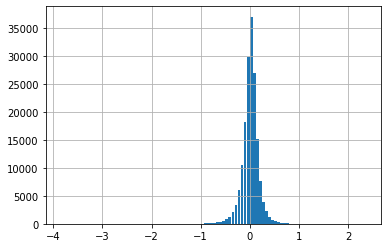

In [6]:
data.lnRET_30.hist(bins=100, rwidth =0.9), data['lnRET_30'].max(),data['lnRET_30'].min()

In [7]:
data = pd.read_parquet('Data/IBES_CRSP_Merged_PR_2003_2019_v01.parquet')
data = data.sort_values(by = 'IBES_Timestamp', ascending= True)
model_name = "IBES_CRSP_PR_03-19_v01"
bertModel = config['bert_model']
tokenizer = BertTokenizerFast.from_pretrained(bertModel)

text = config['text']
target = config['target']
train_ratio = config['train_ratio']


X = list(data[data[text].notnull()][text].values)
y = list(data[data[text].notnull()][target].values)
index = list(data[data[text].notnull()].index)
split = int(len(X)*train_ratio)

In [8]:
def preprocess(i_path, text, limit =50):
    df = pd.read_parquet(i_path)    
    # substitute text length less 50 to none
    def check_length(t):
        _t = t.split()
        if len(_t) < limit:
            return None
        else:
            return t
    df[text].apply(check_length)
    return df 

In [9]:
len(index),data[text].notnull(),data[text].notnull().count()

(142681,
 1         False
 0         False
 2         False
 4          True
 3         False
           ...  
 171386    False
 171381     True
 171387     True
 171382     True
 171389     True
 Name: text, Length: 171390, dtype: bool,
 171390)

In [10]:
#input_tokenized = tokenizer(X, add_special_tokens = True, padding='max_length', truncation=True, max_length=200, return_tensors='pt')

In [11]:
# torch.save(input_tokenized['input_ids'],"input_id.pt")
# torch.save(input_tokenized['attention_mask'],"attention_mask.pt")


In [12]:
input_tokenized = tokenizer("")
input_tokenized['input_ids'] = torch.load("input_id.pt")
input_tokenized['attention_mask'] = torch.load("attention_mask.pt")


In [13]:
input_tokenized['input_ids'][32]
# torch.unique(input_tokenized['attention_mask'])
# tmp = (input_tokenized['attention_mask']==0).nonzero()
# tmp.shape
# torch.min(tmp,0)
# tmp[8470]

tensor([  101,  2697,  3122, 28678, 14536,  4311,  1037,  3623,  1999,  2959,
         4284,  5658,  3318,  6116,  5526, 19193,  2254, 16215,  2697,  3122,
        28678, 14536, 17235,  2850,  4160,  6053,  4886,  2988,  2959,  4284,
         5658,  3318,  1997,  2454,  2030,  2566, 29454, 12926,  3745,  2029,
         2001,  3020,  2084,  1996,  2454,  2030,  2566, 29454, 12926,  3745,
         2988,  1999,  2959,  4284,  2197,  2095,  2709,  2006,  2779,  7045,
         2001,  1998,  2709,  2006,  2779, 10067,  2001,  2005,  1996,  2959,
         4284,  5658,  3318,  2005,  1996,  2095,  3092,  2285,  2001,  2454,
         2030,  2566, 29454, 12926,  3745,  2164,  1037,  2454,  3176,  9347,
         2005,  5414,  1998, 10084,  6409,  8800,  2000,  2454,  1999,  3293,
        29597,  2008,  2024,  2006,  1037,  2512, 16222,  6820,  2389,  3570,
        13343,  1996,  3176,  9347,  5658,  3318,  2052,  2031,  2042,  2454,
         2030,  2566, 29454, 12926,  3745,  2039,  2013,  1996, 

<BarContainer object of 6662 artists>

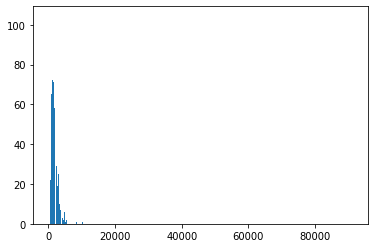

In [14]:
stats = {}
index = {}
for i in range(len(X)):
    l = X[i].split(" ")
    if len(l) in stats.keys():
        stats[len(l)]+=1
        index[len(l)].append(i)
    else:
        stats[len(l)] = 1
        index[len(l)] = [i]
plt.bar(stats.keys(),stats.values())


In [15]:
X[index[91260][0]]

'execution version published cusip number gac syndicated facility agreement dated as of october among interface and certain subsidiaries of the company as borrowers certain subsidiaries of the borrowers as the guarantors bank of america na as administrative agent domestic swing line lender and lc issuer bank of america na australia branch as australian swing line lender bank of america na london branch as european swing line lender bank of america thailand branch as thai swing line lender and the other lenders party hereto the royal bank of scotland plc as syndication agent and suntrust bank and regions bank as co documentation agents arranged by bank of america merrill lynch and rbs securities as joint lead arrangers and joint book managers table of contents i ii iii iv schedules exhibits v syndicated facility agreement this syndicated facility agreement is entered into as of october among interface a georgia corporation the company certain subsidiaries of the company party hereto pur

In [16]:
index[3]
X[index[3][0]]

'txco earnings release'

In [17]:
_t = list(stats.keys())
_t.sort()
count =0
for a in _t:
    if(a<50 or a>4000):
        continue
    else:
        count+=stats[a]
print(count/len(X), count, len(X))


0.9563221452050378 136449 142681


In [18]:
def data_split(input_tokenized,y, split, batch_size = 16):
    input_ids = input_tokenized['input_ids']
    attention_mask = input_tokenized['attention_mask']
    
    train_inputs, test_inputs, y_train, y_test = input_ids[:split], input_ids[split:], y[:split], y[split:]
    train_inputs, val_inputs, y_train, y_val = train_test_split(train_inputs, y_train, random_state=13, test_size=0.1) 
    train_masks, test_masks, y_train, y_test = attention_mask[:split], attention_mask[split:], y[:split], y[split:]
    train_masks, val_masks, y_train, y_val = train_test_split(train_masks, y_train, random_state=13, test_size=0.1) 

    # set(y)
    # print('example train_input:', train_inputs[0])
    # print('example attention_mask', train_masks[0])

    train_labels = torch.tensor(y_train).type(torch.FloatTensor)
    validation_labels = torch.tensor(y_val).type(torch.FloatTensor)
    test_labels = torch.tensor(y_test).type(torch.FloatTensor)
    print(train_labels)
    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    # Create the DataLoader for our validation set.
    validation_data = TensorDataset(val_inputs, val_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return train_dataloader, validation_dataloader, test_dataloader

In [19]:
bert_train_dataloader, bert_validation_dataloader,bert_test_dataloader = data_split(input_tokenized,y, split,1)

tensor([-0.0675,  0.0389, -0.0894,  ...,  0.1202, -0.7307, -0.0696])


In [20]:
class BertRegressor_MLP(BertForSequenceClassification):
    def __init__(self, config):
        super(BertRegressor_MLP, self).__init__(config)
        # self.classifier = nn.Sequential(
        #     nn.Linear(config.hidden_size, 600),
        #     nn.ReLU(),
        #     nn.Linear(600, 500),
        #     nn.ReLU(),
        #     nn.Linear(500, 400),
        #     nn.ReLU(),
        #     nn.Linear(400, 300),
        #     nn.ReLU(),
        #     nn.Linear(300, 200),
        #     nn.ReLU(),
        #     nn.Linear(200, 100),
        #     nn.ReLU(),
        #     nn.Linear(100, 50),
        #     nn.ReLU(),
        #     nn.Linear(50, config.num_labels)
        #     )

In [21]:
from transformers import AdamW, BertConfig

model_freeze_bert = BertRegressor_MLP.from_pretrained(
    "bert-base-uncased", 
    num_labels = 1, 
    output_attentions = False, 
    output_hidden_states = False,
)
for name, param in model_freeze_bert.named_parameters():
	if 'classifier' not in name: 
		param.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertRegressor_MLP: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertRegressor_MLP from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertRegressor_MLP from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertRegressor_MLP were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['

In [22]:
model_finetune_bert = BertRegressor_MLP.from_pretrained(
    "bert-base-uncased", 
    num_labels = 1,    
    output_attentions = False, 
    output_hidden_states = False,
)

RELOAD = False
if RELOAD:
    model_finetune_bert.load_state_dict(torch.load("./" + text+ "-output/finetune/emb-200/pytorch_model.bin"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertRegressor_MLP: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertRegressor_MLP from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertRegressor_MLP from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertRegressor_MLP were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['

In [23]:
import time
from transformers import get_linear_schedule_with_warmup
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))
    
def train_model(model, epochs, train_dataloader, validation_dataloader, device):      
    optimizer = AdamW(model.parameters(),
                  lr = 1e-5, 
                  eps = 1e-8 
                )
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 10, 
                                            num_training_steps = total_steps)
    loss_values = []
    eval_accs = []
    model = model.to(device)
    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        t0 = time.time()

        total_loss = 0
        model.train()

        for step, batch in enumerate(train_dataloader):

            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # This will return the loss (rather than the model output) because we
            # have provided the `labels`.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
            
            # The call to `model` always returns a tuple, so we need to pull the 
            # loss value out of the tuple.
            loss = outputs[0]
            print(outputs)
            # print("train set")
            # for i in range(outputs[1].shape[0]):
            #     print(outputs[1][i], b_labels[i])
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)            
        
        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.8f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
            

        print("Running Validation...")

        t0 = time.time()
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            # batch = tuple(t for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have
                # not provided labels.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask)
            
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            logits = outputs[0]
            
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            print(logits, label_ids)
            # Calculate the accuracy for this batch of test sentences.
            # for i in range(logits.shape[0]):
            #     print(logits[i], label_ids[i])
            tmp_eval_loss = mean_squared_error(logits, label_ids)
            # Accumulate the total accuracy.
            eval_loss += tmp_eval_loss
            # Track the number of batches
            nb_eval_steps += 1

        avg_eval_acc = eval_loss/nb_eval_steps
        print("  Loss: {0:.8f}".format(avg_eval_acc))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))
        eval_accs.append(avg_eval_acc)
    print("")
    print("Training complete!")
    return loss_values, eval_accs

In [24]:
torch.cuda.empty_cache()
torch.cuda.memory_summary()
import gc
gc.collect()


KeyError: 'allocated_bytes.all.current'

In [25]:
type(y[0])

numpy.float64

In [26]:
fine_bert_loss_vals, fine_bert_eval_accs = train_model(model_freeze_bert, 300, 
                                    bert_train_dataloader,
                                    bert_validation_dataloader, 'cuda') 

AssertionError: Torch not compiled with CUDA enabled